## 230523 Starting Metabolomics analysis for spring metabolon experiment
Aim to:
- organize data using the metadata, sort data into vehicle and 2HB, exclude the DEG samples for now
- Conduct differential abundance analysis, enrichment analysis, pathway analysis, hypothesis testing (BCAA metabolism)
- Plot data for final output

In [260]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

### Data organization
- Data is in two separate files, one for serum and one for muscle. This is because the serum had a greater number of metabolites identified. Keep the analysis parallel for this reason.
- we will want to take the Peak Area Data, because we want to re-do the normalization without the DEG samples
    - We will follow the metabolon analysis method of batch normalization, 
    - imputing a minimum value to empty cells where at least half of the cells are present,
    - and then a natural log transformation
- All serum samples were run in a single batch, all muscle samples were run in a single batch, thus no batch normalization is required

In [261]:
path = '/Users/brennanwadsworth/Library/CloudStorage/OneDrive-KI.SE/Documents/BJW Experiments/BJW0037_Metabolon 2HB and exercise/UCAM-01-22-VW+/'
muscle_file = 'UCAM-01-22VW+ MUSCLE DATA TABLES'
serum_file = 'UCAM-01-22VW SERUM DATA TABLE'
# metabolite data
serum_df = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Peak Area Data' )
serum_df = serum_df.set_index('PARENT_SAMPLE_NAME')
muscle_df = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Peak Area Data' )
muscle_df = muscle_df.set_index('PARENT_SAMPLE_NAME')
# chemical meta data and chemicals identified to be related to BCAA metabolism
muscle_chemicals = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Chemical Annotation' )
serum_chemicals = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Chemical Annotation' )
sel_chemicals = pd.read_excel(f'{path}selectmetabolites.xlsx',sheet_name='SERUM_select' )
# sample metadata
serum_samples = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Sample Meta Data' )
muscle_samples = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Sample Meta Data' )
print(muscle_df.shape,'\n', serum_df.shape,'\n',sel_chemicals.shape)

(72, 845) 
 (36, 1071) 
 (60, 6)


serum table has 36 samples and 1071 metabolites

In [262]:
import re

def fix_chemicals (df_col):
    # goal is to remove all non alpha characters from chemical names so that they do not cause an error in the ANOVA calculation
    # input a dataframe and then column containing the chemicals
    # return a list of new column names to be assigned to a new column in the df
    pattern = r'[0-9]'
    name = list()
    for chem in df_col:
        new_str = re.sub(r'[\W_]', '', chem)
        new_str = re.sub(pattern,"",new_str)
        name.append(new_str)
    return name

muscle_chemicals['NEW_NAME'] = fix_chemicals(muscle_chemicals.PLOT_NAME)
serum_chemicals['NEW_NAME'] = fix_chemicals(serum_chemicals.PLOT_NAME)
sel_chemicals['NEW_NAME'] = fix_chemicals(sel_chemicals.PLOT_NAME)
sel_chemicals['NEW_UNIQUE_NAME'] = fix_chemicals(sel_chemicals.UNIQUE_NAME)

muscle_chemicals.to_csv('muscle_chemicals.csv')
serum_chemicals.to_csv('serum_chemicals.csv')


In [263]:
serum_df.columns = serum_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
muscle_df.columns = muscle_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
# df = df.drop(df.iloc[:,776:len(df.columns)],axis=1)
# df.columns = sel_chemicals.NEW_UNIQUE_NAME

# Select the rows in the sample meta data that are either 2HB or Veh, select df to match
muscle_samples_sel = muscle_samples.copy()[muscle_samples.DRUG2 != 'DEG']
muscle_sel = muscle_df.copy()[muscle_df.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
serum_samples_sel = serum_samples.copy()[serum_samples.DRUG2 != 'DEG']
serum_sel = serum_df.copy()[serum_df.index.isin(serum_samples_sel.PARENT_SAMPLE_NAME)]
# select proper gastrocnemius
muscle_samples_sel = muscle_samples.copy()[muscle_samples.GASTROCNEMIUS != 'White']
muscle_sel = muscle_sel.copy()[muscle_sel.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 24 out of 36 rows, correct

# select chemicals of interest
muscle_sel = muscle_sel.copy().loc[:,muscle_sel.columns.isin(sel_chemicals.NEW_NAME)]
serum_sel = serum_sel.copy().loc[:,serum_sel.columns.isin(sel_chemicals.NEW_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 97 out of 1071 chemicals

(24, 845) 
 (24, 1071)
(24, 47) 
 (24, 60)


In [264]:
# drop duplicated columns - these are all metabolites we are not interested in
dup = muscle_sel.columns[muscle_sel.columns.duplicated()]
muscle_sel = muscle_sel.drop(dup,axis=1)
dup = serum_sel.columns[serum_sel.columns.duplicated()]
serum_sel = serum_sel.drop(dup,axis=1)

In [265]:
muscle_na = muscle_sel.dropna(axis=1,thresh=6)
serum_na = serum_sel.dropna(axis=1,thresh=6)
print(f'removed {serum_sel.shape[1] - serum_na.shape[1]} rows in serum file and {muscle_sel.shape[1] - muscle_na.shape[1]} in muscle')

removed 0 rows in serum file and 0 in muscle


In [266]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))

samples_2HB = muscle_samples[muscle_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
muscle_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
muscle_na['Tx'] = muscle_na.Group.str[0]
muscle_na['Ex'] = muscle_na.Group.str[1]
samples_2HB = serum_samples[serum_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
serum_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
serum_na['Tx'] = serum_na.Group.str[0]
serum_na['Ex'] = serum_na.Group.str[1]



In [267]:
# impute based on group values

def impute_by_group(df,grouping_col):
    # calcluate group values
    grouped = df.groupby(grouping_col) # organize data by groups
    holder_df = pd.DataFrame()
    for group in df[grouping_col].unique():
        new_df = grouped.get_group(group)
        new_df = new_df.fillna(new_df.select_dtypes(include=np.number).min())
        holder_df = pd.concat([holder_df,new_df])
    return holder_df


muscle_na = impute_by_group(muscle_na,'Ex')
serum_na = impute_by_group(serum_na,'Ex')


In [268]:
# impute na with col minimum, create a log-transform df to see if this helps with the probably skewed data
def met_transform(df, scale_by, to_log, standard):
    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns = df.select_dtypes(include=object)
    # function will take a df with index of sample ID and columns of raw metabolite values
    # For now, function will always impoute with column min
    # For now, scale_by will accept either 0 for no scaling, 1 for median scaling, or 2 for mean scaling
    # to_log will accept a 0 for no log transformation, or 1 for natural log transformation
    # standard accepts 0 or 1, if 1 then function will standardize columns
    df = df.drop(object_columns.columns,axis=1).fillna(df.min(axis=0))

    if scale_by == 1:
        df = df.div(df.median())
    elif scale_by == 2:
        df = df.div(df.mean())
    if to_log == 1:
        df = (np.log(df))
    if standard == 1:
        scaler = StandardScaler()
        df_scale = pd.DataFrame(scaler.fit_transform(df))
        df_scale = df_scale.set_index(df.index)
        df_scale.columns = df.columns
        df = df_scale
        df = pd.merge(left=df,right=object_columns,how='left',left_index=True,right_index=True) # add back object columns
    return df



In [269]:
muscle_log = met_transform(muscle_na,0,1,1)
serum_log = met_transform(serum_na,0,1,1)
muscle_med = met_transform(muscle_na,1,1,1)
serum_med = met_transform(serum_na,1,1,1)


*** Log transformation only improved normality to 67% of columns instead of 59% in the non-transformed data
*** So, we could consider conducting feature-wise normalization of the metabolites, so that we only log transform the columns that benefit from doing so, and then we scale everything to a mean of 0 and SD of 1, 

In [270]:
def fwn (df1, df2):
    # takes two dataframes of the same size with the same index and selects the columns that are most normally distributed and returns a single df
    # conducts shapiro-wilks test for each column and compares the p values to select optimal method

    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns1 = df1.select_dtypes(include=object)
    object_columns2 = df2.select_dtypes(include=object)
    df1 = df1.drop(object_columns1.columns,axis=1)
    df2 = df2.drop(object_columns2.columns,axis=1)

    res1 = list()
    pval1 = list()
    for col in df1.columns:
        shap_test = shapiro(df1.loc[:,col])
        res1.append(shap_test.pvalue > 0.05)
        pval1.append(shap_test.pvalue)
    norm_prop1 = sum(res1)/len(res1)
    res2 = list()
    pval2 = list()
    for col in df2.columns:
        shap_test = shapiro(df2.loc[:,col])
        res2.append(shap_test.pvalue > 0.05)
        pval2.append(shap_test.pvalue)
    norm_prop2 = sum(res2)/len(res2)
    print(f'The propotion of normally distributed columns with method_1 is: {norm_prop1}','\n',
        f'The proportion of normally distributed columns with method_2 is: {norm_prop2}')

    shap_df = pd.DataFrame({'pval1':pval1, 'pval2':pval2})
    shap_df['method_2'] = shap_df.pval2 > shap_df.pval1
    shap_df = shap_df.set_index(df1.columns).T
    df_fwn = df1.drop(shap_df.loc[:,shap_df.loc['method_2',:] == True].columns, axis = 1)
    print(f'take {df_fwn.shape[1]} columns from method 1')
    df_fwn = df_fwn.join(df2.drop(shap_df.loc[:,shap_df.loc['method_2',:] == False].columns, axis = 1), on = 'PARENT_SAMPLE_NAME', how = 'outer')
    print(f'take remaining columns from method 2')
    # object columns are the same between the two, since we are just testing different normalization methods, so only add back one of the object columns
    df_fwn = pd.merge(left = df_fwn, right = object_columns1, how='left',left_index=True,right_index=True) # add back object columns
    return df_fwn


In [271]:
muscle_fwn = fwn(muscle_med,muscle_log)
serum_fwn = fwn(serum_med,serum_log)

The propotion of normally distributed columns with method_1 is: 0.723404255319149 
 The proportion of normally distributed columns with method_2 is: 0.723404255319149
take 47 columns from method 1
take remaining columns from method 2
The propotion of normally distributed columns with method_1 is: 0.6166666666666667 
 The proportion of normally distributed columns with method_2 is: 0.6166666666666667
take 60 columns from method 1
take remaining columns from method 2


Feature-wise normalization has improved Shapiro-Wilk nomrliaty test pass rate to 82%, overall a success. Move forward with mean scaling.

In [272]:
# collect VO2 data and scale
vo2_df = pd.read_csv(f'{path}AVG_dVO2_18mmin.csv')
vo2_df = vo2_df.set_index('PARENT_SAMPLE_NAME')
scaler = StandardScaler()
vo2_scale = pd.DataFrame(scaler.fit_transform(vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1)))
vo2_scale = vo2_scale.set_index(vo2_df.index)
vo2_scale.columns = vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1).columns
vo2_scale['MouseID'] = vo2_df['MouseID']
vo2_scale.head()


,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2,MouseID
PARENT_SAMPLE_NAME,,,,,,
UCAM-55688,0.292980,0.448845,0.421998,0.372656,0.177744,VR11
UCAM-55724,-0.223137,0.340126,-0.080347,0.078725,-0.587017,VR42
UCAM-55694,0.595730,0.284979,0.467792,0.225422,0.225418,VR60
UCAM-55730,0.582898,0.616650,0.643768,1.028224,1.079038,VR72
UCAM-55700,-0.535343,0.142384,-0.403397,1.162024,0.996155,VR83


In [273]:
# add VO2 columns matching by index
muscle_fwn = pd.merge(left = muscle_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
muscle_fwn = muscle_fwn.set_index('MouseID')
muscle_fwn.head()

,alphaketoglutarate,hydroxyisobutyrate,hydroxymethylglutarate,phosphoglycerate,hypoxanthine,succinate,hydroxybutyrateBHBA,dihydroxyacetonephosphateDHAP,fumarate,isoleucine,...,hydroxybutyratehydroxyisobutyrate,dihydroxymethylbutyrate,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,-1.826174,-0.276181,-0.635140,1.521123,1.706764,-0.076182,-0.137823,-0.155031,1.368142,1.060958,...,-0.617765,1.358193,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
HR40,-0.604048,0.679963,-0.545750,-0.015442,1.147125,-0.200901,0.892883,0.376715,0.293652,0.513750,...,-0.390560,1.219453,HR,H,R,1.622066,2.154468,1.571252,0.186733,-0.585547
VR60,0.489360,-1.101804,1.899008,-0.374624,0.206269,-0.334345,-0.995647,0.466238,0.526490,-0.697483,...,0.473637,-0.601991,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418
HR70,0.018801,1.155001,-0.309811,0.715262,0.628818,-0.181247,0.615232,1.351890,-0.863751,-0.026311,...,0.691840,-0.520375,HR,H,R,1.450905,1.606147,1.460918,1.019089,0.939831
VR83,2.011026,1.213795,1.403708,-1.243140,0.602417,-0.514258,1.188630,0.551877,-0.490731,-0.656866,...,0.831951,0.400457,VR,V,R,-0.535343,0.142384,-0.403397,1.162024,0.996155


In [274]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))
# add VO2 columns matching by index
serum_fwn = pd.merge(left = serum_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
serum_fwn = serum_fwn.set_index('MouseID')
serum_fwn.head()

,alphaketoglutarate,hydroxyisobutyrate,hydroxymethylglutarate,phosphoglycerate,hypoxanthine,succinate,hydroxybutyrateBHBA,glucosephosphate,dihydroxyacetonephosphateDHAP,fumarate,...,dihydroxymethylbutyrate,isocaproylcarnitine,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,1.183489,-0.009661,-0.207900,1.059161,0.023355,0.236337,-1.260088,0.680033,1.519812,1.266707,...,0.149920,0.064103,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
HR40,0.950370,0.066502,0.979453,0.508929,0.655574,0.258693,0.995554,-0.788214,0.675864,0.743885,...,-1.525900,1.235724,HR,H,R,1.622066,2.154468,1.571252,0.186733,-0.585547
VR42,1.252783,1.718783,0.133138,0.175097,0.421604,-0.624476,1.093364,-1.054361,0.066878,-0.050595,...,0.167658,-0.049351,VR,V,R,-0.223137,0.340126,-0.080347,-0.566096,-1.160123
HR52,1.041421,0.318827,0.763387,-0.948760,0.589586,0.789305,0.734796,-0.113988,-0.130703,-1.266154,...,-0.280867,-0.049351,HR,H,R,0.496940,0.934140,0.284133,0.542459,0.196349
VR60,1.230285,0.081521,-0.229038,0.437224,0.579304,0.235686,-0.896080,0.343548,0.867403,0.028739,...,0.140492,1.017777,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418


In [275]:
# save data files as csv for other uses
serum_fwn.to_csv('serum_fwn.csv')
muscle_fwn.to_csv('muscle_fwn.csv')

In [276]:
# conduct basic differential abundance analysis
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
import seaborn as sns


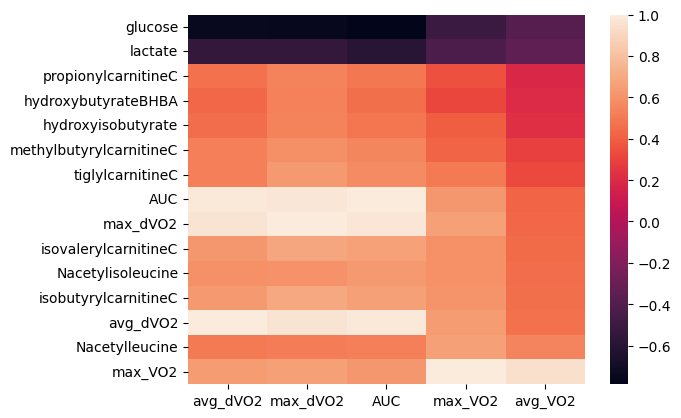

In [277]:
corr_matrix1 = muscle_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix2 = serum_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix1 = corr_matrix1.drop(corr_matrix1.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
corr_matrix2 = corr_matrix2.drop(corr_matrix2.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
sns.heatmap(corr_matrix1[abs(corr_matrix1.max_dVO2) > 0.5],annot=False)
plt.show()

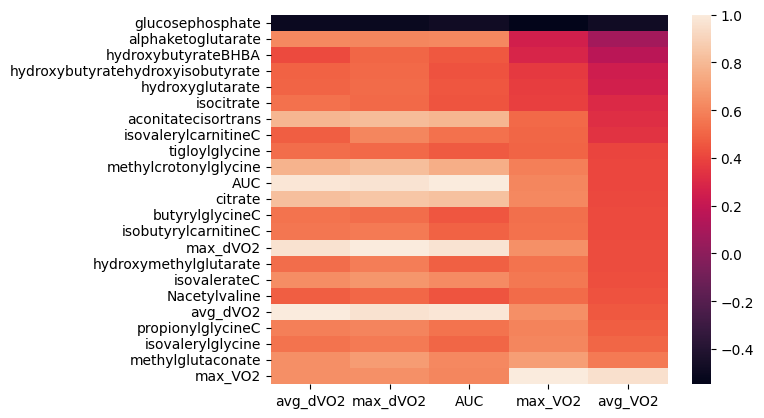

In [278]:
sns.heatmap(corr_matrix2[abs(corr_matrix2.max_dVO2) > 0.5],annot=False)
plt.show()

## Serum linear model and adjusting means for exercise

*** Conceptualizing linear adjustment for covariates
- Imagine that we want to compare blood pressure in two different cities, but the individuals in each city are different ages
- We know that blood pressure is affected by age, and we are going ot assume in a linear fashion
- We want to convert the blood pressure values to age-adjusted-blood pressure, that is, what the blood pressure would be in each individual adjusting for the age covariate
- We run a linear model (bp ~ age)
- How high or low someones blood pressure is after adjustment for age is the residual value, i.e. the distance from the data-point to the linear regression model, plus the intercept value.
    - The intercept value gives a baseline blood pressure, e.g. 100, and the residual gives the value difference.

In [294]:
serum_adj = pd.DataFrame(columns=serum_fwn.columns)
results = pd.DataFrame(columns=['Metabolite','AIC','VS','VS_SDev','HS','HS_SDev','VR','VR_SDev','HR','HR_SDev'])
covars=['max_dVO2']
for met in serum_fwn.columns[:-8]:
    # print(met) # for tracking progress in loop
    model = ols(formula=f'{met} ~ {covars[0]}', data=serum_fwn).fit()
    # C(Group) tells the model to expect a categorical variable
    aic = model.aic
    # to get the adjusted means, add the intercept to the residuals, then subset based on group and then take the average and stdev
    group_means = model.resid
    means = group_means[serum_fwn['Group'] == 'VS'].mean(), group_means[serum_fwn['Group'] == 'VR'].mean(), group_means[serum_fwn['Group'] == 'HS'].mean(), group_means[serum_fwn['Group'] == 'HR'].mean()
    std_dev = group_means[serum_fwn['Group'] == 'VS'].std(), group_means[serum_fwn['Group'] == 'VR'].std(), group_means[serum_fwn['Group'] == 'HS'].std(), group_means[serum_fwn['Group'] == 'HR'].std()

    serum_adj[met] = group_means

    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'AIC': aic,
        'VS': means[0],
        'VR': means[1],
        'HS': means[2],
        'HR': means[3],
        'VS_SDev': std_dev[0],
        'VR_SDev': std_dev[1],
        'HS_SDev': std_dev[2],
        'HR_SDev': std_dev[3]
    })

serum_adj['Group'] = serum_fwn['Group']
serum_adj['Tx'] = serum_fwn['Tx']
serum_adj['Ex'] = serum_fwn['Ex']
serum_adj['avg_VO2'] = serum_fwn['avg_VO2']
serum_adj['avg_dVO2'] = serum_fwn['avg_dVO2']
serum_adj = serum_adj.drop(['max_dVO2','max_VO2','AUC'],axis=1)
serum_adj.to_csv('serum_adjusted_values.csv')


In [295]:
serum_adj.head()

,alphaketoglutarate,hydroxyisobutyrate,hydroxymethylglutarate,phosphoglycerate,hypoxanthine,succinate,hydroxybutyrateBHBA,glucosephosphate,dihydroxyacetonephosphateDHAP,fumarate,...,hydroxyglutarate,methylglutaconate,hydroxybutyratehydroxyisobutyrate,dihydroxymethylbutyrate,isocaproylcarnitine,Group,Tx,Ex,avg_dVO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,0.849978,-0.253920,-0.522347,1.072968,-0.029739,0.235742,-1.533844,0.958143,1.462773,1.200019,...,0.444878,0.061972,-0.953844,-0.067747,-0.179626,VR,V,R,0.292980,0.177744
HR40,-0.578540,-1.053253,-0.462063,0.572223,0.412180,0.255963,-0.259424,0.486722,0.414381,0.438167,...,-0.573520,-1.083268,-0.553774,-2.523746,0.118403,HR,H,R,1.622066,-0.585547
VR42,0.995469,1.530329,-0.109468,0.185750,0.380641,-0.624935,0.882152,-0.839790,0.022870,-0.102047,...,-0.328519,0.186216,0.213435,-0.000279,-0.237396,VR,V,R,-0.223137,-1.160123
HR52,0.367787,-0.174534,0.128259,-0.920873,0.482347,0.788102,0.181856,0.447746,-0.245911,-1.400852,...,0.594236,-0.282369,0.690278,-0.720515,-0.541640,HR,H,R,0.496940,0.196349
VR60,1.011621,-0.078626,-0.435203,0.446276,0.544494,0.235295,-1.075567,0.525889,0.830006,-0.014985,...,0.752208,-0.501640,-0.193213,-0.002220,0.857978,VR,V,R,0.595730,0.225418


### Serum group comparisons

In [296]:
grouped = serum_adj.groupby('Group') # organize data by groups
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in serum_adj.columns[:-8]:
    VS = grouped.get_group('VS')[met]
    VR = grouped.get_group('VR')[met]
    HS = grouped.get_group('HS')[met]
    HR = grouped.get_group('HR')[met]
    #perform test
    test_stat, p_value = ttest_ind(VR, HR)
    # append data to the results table
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
    test_stat, p_value = ttest_ind(VS, HS)
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'S'
        })
    
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('serum_FDR.csv')
ser_hit_results = results[results.reject == True]
serum_DE = serum_adj[ser_hit_results.Metabolite.unique()]
serum_DE['Group'] = serum_adj['Group']
print(results.reject.value_counts(),'\n',serum_adj.shape, serum_DE.shape)


reject
False    93
True     21
Name: count, dtype: int64 
 (24, 65) (24, 22)


/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_26559/2296763398.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serum_DE['Group'] = serum_adj['Group']


In [297]:
serum_DE.head()


,hydroxymethylglutarate,lactate,tigloylglycine,isocitrate,methylsuccinate,ethylmalonate,isovalerateC,acetylcarnitineC,propionylglycineC,butyrylglycineC,...,hydroxyethylpropionate,aconitatecisortrans,isovalerylcarnitineC,valerylcarnitineC,methylbutyrylcarnitineC,betahydroxyisovaleroylcarnitine,deoxycarnitine,hydroxyglutarate,methylglutaconate,Group
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,-0.522347,0.710787,-0.538281,-0.537557,0.117304,-0.187999,0.140230,-0.058038,0.007917,-0.471860,...,-1.401187,0.140280,-0.108570,-0.100322,0.674844,0.354179,0.011705,0.444878,0.061972,VR
HR40,-0.462063,1.148012,-0.709260,0.539595,-0.516941,-0.609227,-0.416472,0.876049,-1.268045,-0.601371,...,-0.391457,-0.853451,-0.507902,-0.877429,0.220394,0.800437,-0.037508,-0.573520,-1.083268,HR
VR42,-0.109468,-0.711617,-0.718329,-0.232272,-0.344235,-0.827725,0.969139,0.434547,0.483822,-0.478457,...,-0.223389,0.570428,1.555867,-0.264198,-0.048347,-0.261000,-0.548819,-0.328519,0.186216,VR
HR52,0.128259,1.253809,0.492890,-0.527649,-0.235414,0.504584,-0.603307,0.828771,-0.309463,0.646169,...,0.799166,-0.230726,-0.700715,0.090842,0.413220,-0.321527,0.361397,0.594236,-0.282369,HR
VR60,-0.435203,0.165211,0.170695,0.269343,-0.252136,0.125783,0.215759,0.192825,-0.191700,0.216630,...,-1.202127,0.951590,-0.336502,1.125591,0.633158,0.418815,0.528174,0.752208,-0.501640,VR


## Muscle Linear model adjusting values for exercise 

In [321]:
grouped = muscle_fwn.groupby('Tx') # organize data by Tx
muscle_adj = pd.DataFrame(columns=muscle_fwn.columns) # frame for holding adjusted values

model = ols(formula=f'{met} ~ {covars[0]}', data=grouped.get_group('V')).fit()
hb_adj = grouped.get_group('H')[met] - model.predict(grouped.get_group('H'))
veh_adj = model.resid

muscle_adj[met] = pd.concat([hb_adj,veh_adj],axis=0)


In [298]:
muscle_adj = pd.DataFrame(columns=muscle_fwn.columns) # frame for holding adjusted values
results = pd.DataFrame(columns=['Metabolite','AIC','VS','VS_SDev','HS','HS_SDev','VR','VR_SDev','HR','HR_SDev']) # frame for summarizing adjusted values

covars=['avg_dVO2']
for met in muscle_fwn.columns[:-8]:
    # print(met) # for tracking progress in loop
    model = ols(formula=f'{met} ~ {covars[0]}', data=muscle_fwn[muscle_fwn.Tx == 'V']).fit()
    # C(Group) tells the model to expect a categorical variable
    aic = model.aic
    # to get the adjusted means, add the intercept to the residuals, then subset based on group and then take the average and stdev
    group_means = model.resid
    means = group_means[muscle_fwn['Group'] == 'VS'].mean(), group_means[muscle_fwn['Group'] == 'VR'].mean(), group_means[muscle_fwn['Group'] == 'HS'].mean(), group_means[muscle_fwn['Group'] == 'HR'].mean()
    std_dev = group_means[muscle_fwn['Group'] == 'VS'].std(), group_means[muscle_fwn['Group'] == 'VR'].std(), group_means[muscle_fwn['Group'] == 'HS'].std(), group_means[muscle_fwn['Group'] == 'HR'].std()

    muscle_adj[met] = group_means



    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'AIC': aic,
        'VS': means[0],
        'VR': means[1],
        'HS': means[2],
        'HR': means[3],
        'VS_SDev': std_dev[0],
        'VR_SDev': std_dev[1],
        'HS_SDev': std_dev[2],
        'HR_SDev': std_dev[3]

    })

muscle_adj['Group'] = muscle_fwn['Group']
muscle_adj['Tx'] = muscle_fwn['Tx']
muscle_adj['Ex'] = muscle_fwn['Ex']
muscle_adj['avg_VO2'] = muscle_fwn['avg_VO2']
muscle_adj['avg_dVO2'] = muscle_fwn['avg_dVO2']
muscle_adj = muscle_adj.drop(['max_dVO2','max_VO2','AUC'],axis=1)
muscle_adj.to_csv('muscle_adjusted_values.csv')


### Muscle group comparisons and testing

In [299]:
grouped = muscle_adj.groupby('Group') # organize data by groups
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in muscle_adj.columns[:-8]:
    VS = grouped.get_group('VS')[met]
    VR = grouped.get_group('VR')[met]
    HS = grouped.get_group('HS')[met]
    HR = grouped.get_group('HR')[met]
    #perform test
    test_stat, p_value = ttest_ind(VR, HR)
    # append data to the results table
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
    test_stat, p_value = ttest_ind(VS, HS)
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'S'
        })
    
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('muscle_FDR.csv')
mus_hit_results = results[results.reject == True]
muscle_DE = muscle_adj[mus_hit_results.Metabolite.unique()]
muscle_DE['Group'] = muscle_adj['Group']
print(results.reject.value_counts(),'\n',muscle_adj.shape, muscle_DE.shape)


reject
False    88
Name: count, dtype: int64 
 (24, 52) (24, 1)


/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_26559/1658350859.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_DE['Group'] = muscle_adj['Group']


### Clustering

In [300]:
muscle_adj

,alphaketoglutarate,hydroxyisobutyrate,hydroxymethylglutarate,phosphoglycerate,hypoxanthine,succinate,hydroxybutyrateBHBA,dihydroxyacetonephosphateDHAP,fumarate,isoleucine,...,succinylcarnitineCDC,hydroxyglutarate,methylglutaconate,hydroxybutyratehydroxyisobutyrate,dihydroxymethylbutyrate,Group,Tx,Ex,avg_dVO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,-1.722501,-0.484996,-0.707051,1.499335,1.555976,-0.190939,-0.336382,-0.376142,1.429113,0.954044,...,0.404782,-0.120906,0.788809,-0.811960,1.389261,VR,V,R,0.292980,0.177744
HR40,-0.105848,-0.323491,-0.891313,-0.120142,0.422517,-0.752365,-0.061287,-0.685826,0.586646,-0.000022,...,0.340609,-1.197024,-0.832334,-1.323757,1.368748,HR,H,R,1.622066,-0.585547
VR60,0.682902,-1.491628,1.764762,-0.415298,-0.075228,-0.548579,-1.366326,0.053459,0.640313,-0.897075,...,-0.995622,-0.328240,0.372472,0.111107,-0.543993,VR,V,R,0.595730,0.225418
HR70,0.466193,0.253881,-0.620133,0.621240,-0.021893,-0.676471,-0.241630,0.397709,-0.600637,-0.487687,...,-0.289661,-0.240978,-0.844374,-0.146187,-0.386306,HR,H,R,1.450905,0.939831
VR83,1.868820,1.500221,1.502346,-1.213255,0.809249,-0.356849,1.460988,0.855168,-0.574363,-0.510215,...,0.299558,0.562450,0.986936,1.098323,0.357842,VR,V,R,-0.535343,0.996155
HR92,-0.444633,0.226873,1.050802,0.039147,-0.301921,-0.435912,0.139524,0.089782,0.036727,-1.325953,...,-0.104539,0.490008,-0.318534,-0.482807,0.105836,HR,H,R,0.556003,-0.499269
VR42,1.098069,1.456335,0.604159,1.283938,1.129490,0.600373,1.142363,-1.209438,1.868947,0.725036,...,2.022950,2.371073,1.061897,1.111162,1.701288,VR,V,R,-0.223137,-0.587017
HR52,0.048830,0.968054,-0.543379,-0.075454,0.084746,0.015220,0.196076,0.036975,0.809859,0.948504,...,0.084511,0.750095,-0.208517,-0.578644,1.113927,HR,H,R,0.496940,0.196349
VR72,-0.463657,1.775198,-0.526822,0.559901,1.344390,0.099540,1.469332,0.604231,-0.690074,1.986049,...,-0.805972,-0.385826,0.661811,2.315338,-0.402858,VR,V,R,0.582898,1.079038


In [301]:
import seaborn as sns

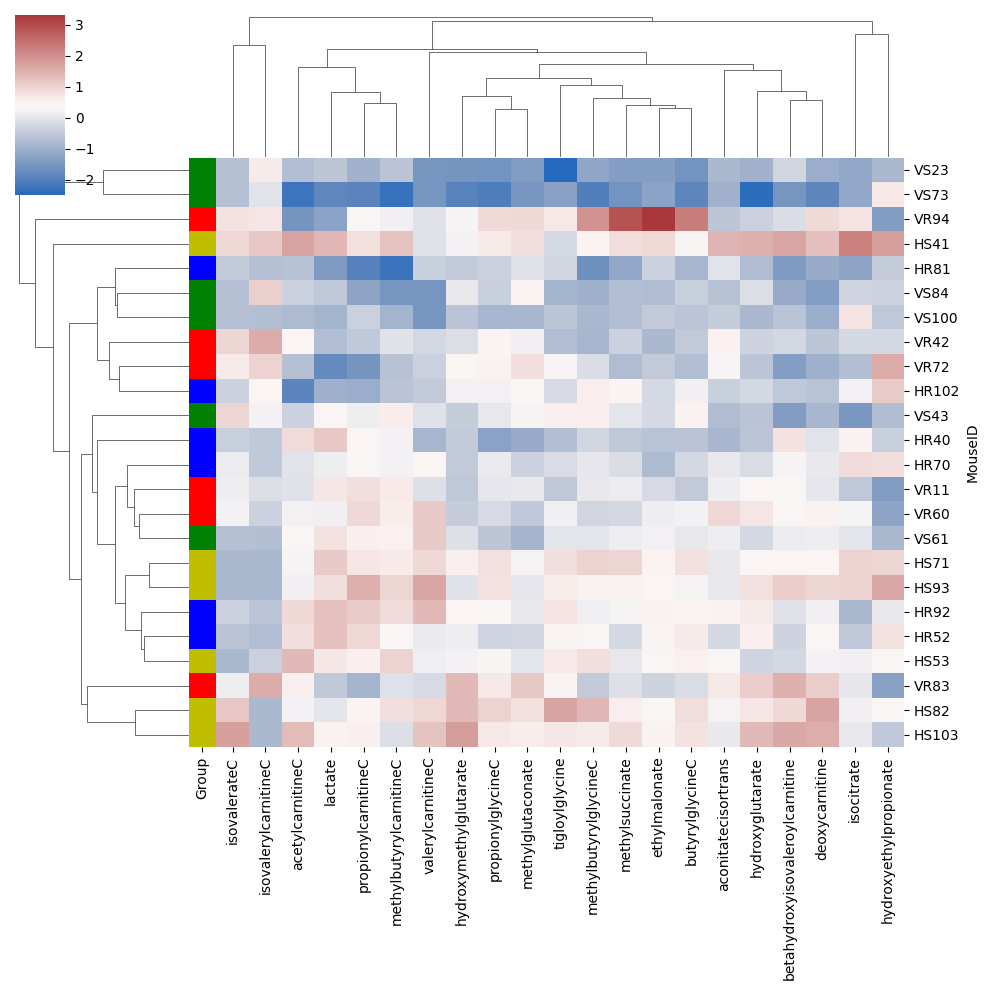

In [304]:
lut = dict(zip(serum_DE.Group.unique(), "rbgy"))
row_colours = serum_DE.Group.map(lut)
sns.clustermap(serum_DE.select_dtypes(include=np.number),row_colors=row_colours,cmap='vlag',method='average',metric='seuclidean')

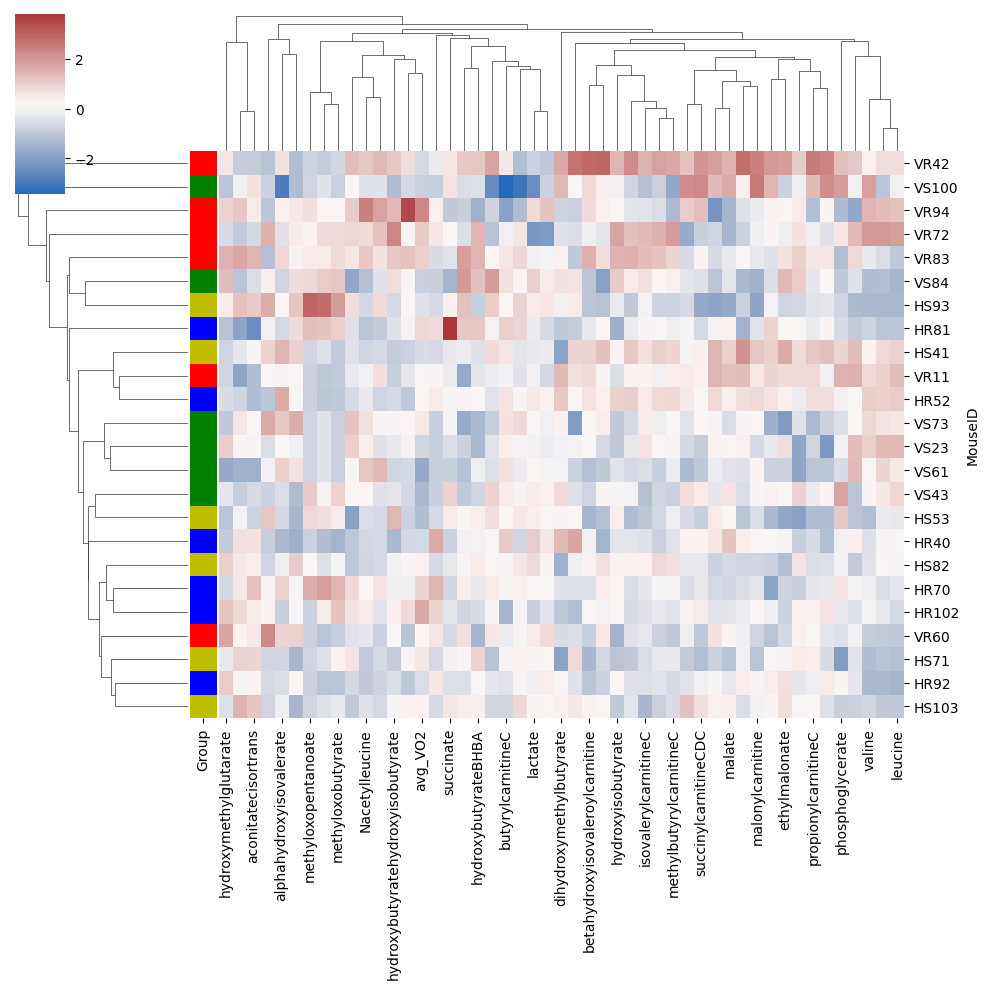

In [303]:
lut = dict(zip(muscle_adj.Group.unique(), "rbgy"))
row_colours = muscle_adj.Group.map(lut)
sns.clustermap(muscle_adj.select_dtypes(include=np.number),row_colors=row_colours,cmap='vlag',method='average',metric='seuclidean')

## Over-representation analysis

In [289]:
from scipy.stats import hypergeom


plan is to take the muscle_DE and serum_DE and check for over-representation of any of the matabolic sub_pathways (e.g. BCAA degradation instead of super_pathway 'amino acid')

Recall the concept: there is a bucket of M balls, consisting of (n) black and (M-n) white balls. We select N balls without replacement, and want to calculate the probability distribution for black ball selection. E.g., what is the probability of selecting at least k balls, gives p value.
For us, in a pool of ~1000 metabolites, ~ 40 are related to BCAA metabolism, if ~ 200 metabolites are differentially abundant, what is the probability that x metabolites from BCAA metabolism are significant? If less than 0.05, ***

can calculate fold enrichment, in form of observed/expected  - > (differentially abundant BCAA / total differentially abundant) / (BCAA/total)

In [290]:
def Over_rep(df,chem_df):
    # plan to take the hit_results df. Find the Metabolite in the chemicals df under NEW_NAME. conduct appropriate enrichment analyses
    hit_set = set(df.Metabolite) # all significant metabolites, i.e. total balls drawn from bucket
    N = len(hit_set)
    M = len(set(chem_df.NEW_NAME)) # all chemicals assessed, i.e. total balls in bucket
    pathways = set(chem_df.SUB_PATHWAY) # all pathways
    scores = pd.DataFrame(columns=['Pathway','Enrichment_Score','p_value'])
    for pathway in pathways:
        metabolite_set = set(chem_df[chem_df.SUB_PATHWAY == pathway]['NEW_NAME']) # total chemicals in pathway of interest, i.e. count of black balls
        match_set = set.intersection(metabolite_set,hit_set) # chemicals in path of interest that are significant, i.e. number of black balls drawn out of bucket
        [k, n] = [len(match_set), len(metabolite_set)]
        # print(pathway,'\n',match_set)
        enrichment_score = (k/N)/(n/M) # fold enrichment
        hg = hypergeom(M, n, N)
        p_value = hg.sf(k) # probability of having this many, or more, hits in the pathway of interest 
        scores.loc[len(scores)] = pd.Series({
            'Pathway':pathway,
            'Enrichment_Score':enrichment_score,
            'p_value':p_value
        })
    return scores

In [291]:
mus_ORA = Over_rep(mus_hit_results[mus_hit_results.Ex == 'R'],sel_chemicals[sel_chemicals.SUPER_PATHWAY == 'Amino Acid'])
mus_ORA.sort_values(by='p_value')

ZeroDivisionError: division by zero

In [ ]:
ser_ORA = Over_rep(ser_hit_results[ser_hit_results.Ex == 'R'],sel_chemicals)
ser_ORA.sort_values(by='p_value')

,Pathway,Enrichment_Score,p_value
54,Docosanoid,2.023095,0.0
16,"Fatty Acid, Branched",2.023095,0.0
80,"Fatty Acid Metabolism (Acyl Carnitine, Short C...",2.023095,0.0
96,Ketone Bodies,2.023095,0.0
10,Dipeptide Derivative,2.023095,0.0
...,...,...,...
4,Tryptophan Metabolism,0.459794,0.990983
62,Fatty Acid Metabolism (Acyl Choline),0.0,0.991739
73,Food Component/Plant,0.58445,0.996627
31,Diacylglycerol,0.252887,0.997774


In [ ]:
M = 20
N = 12
n = 7
k = 5


hg = hypergeom(M,n,N)
hg.sf(k)

0.10557275541795666